In [1]:
# -- uslu.mserhat2@gmail.com

# RESULTS:
#          (Go To the Very Bottom of the Report for Quick View of the Results)
#
#          - 0.94 Average Accuracy with similar F1 values achieved by Random Forest Algorithm 
#          - 0.88 Average Accuracy with similar F1 values achieved by Desicion Tree Algorithm
#          - 0.87 Average Accuracy with similar F1 values achieved by K-NN 

# BONUS:
#        >>> According to the Categorical Feature Analysis:
#             - Students have the highest chance of subscribing (15%), housemaids have the lowest chance (4%)  [at box 21]
#             - Single and Divorced people have a higher chance of subscribing opposed to Married people       [at box 22]
#             - Education level and subscribtion chance have a positive correlation                            [at box 23]
#             - People who hasn't defauled have a slightly higher chance of subscribing                        [at box 24]
#             - Housing and subscribtion has a negative correlation                                            [at box 25]
#             - Loans and subscribtion has a negative correlation                                              [at box 26]
#             - People who has been contacted by a cellular phone has a higher chance of suscribing            [at box 27]
#
#        >>> According to the Numerical Feature Analysis:
#             - Age > Balance == Duration > Num_ofPeople_in_Campaign is the order of features having higher correlation with "y"

# SUMMARY:
#        *Pre-Processing:
#             -> checked nulls
#             -> dtypes checked 
#             -> Processed Numerical Features
#                  -"y"        1-One Hot Encoding
#                  - "age"      1-outlier analysis 2-standardize 
#                  - "balance   1-outlier analysis 2-standardize
#                  - "day"      1-REMOVE
#                  - "duration  1-outlier analysis 2-standardize
#                  - "campaign" 1-produce "Num_of_ppl_in_campaign" then remove "campaign" 2-standardize
#             -> Processed Categorical Features
#                  - "job"         1-ONE HOT ENCODE         
#                  - "marital"     1-ONE HOT ENCODE
#                  - "education"   1-ONE HOT ENCODE
#                  - "default"     1-ONE HOT ENCODE
#                  - "housing"     1-ONE HOT ENCODE
#                  - "loan"        1-ONE HOT ENCODE
#                  - "contact"     1-ONE HOT ENCODE
#                  - "month"       1-REMOVE
#       
#          *Over-Sampling the yes instances with SMOTE
#           
#          *5-Fold Cross-Validation Split
#
#          *Predictions and Evaluations

In [2]:
from IPython.display import display
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn import preprocessing
from matplotlib import pyplot
import plotly.express as px
from sklearn.cluster import DBSCAN
import warnings
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [3]:
#VERIYI YÜKLÜYORUZ
DataTraining = pd.read_csv(r'C:\Users\Mustafa\Desktop\SiSaSoft\term-deposit-marketing-2020.csv')

In [4]:
#NULL DEĞER KONTROLÜ YAPIYORUZ, null değer yok
print(DataTraining.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


In [5]:
#VERİ SETİNE GÖZ ATIYORUZ
DataTraining.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [6]:
#VERİ TİPLERİNİ KONTROL EDİYORUZ 
print(DataTraining.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object


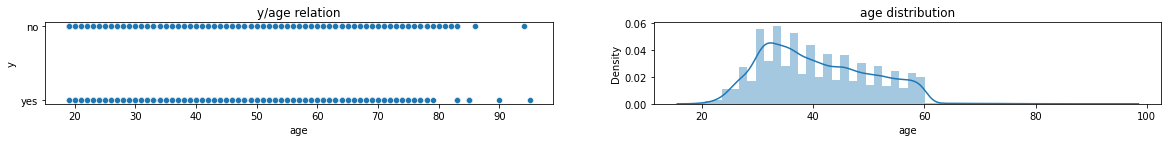

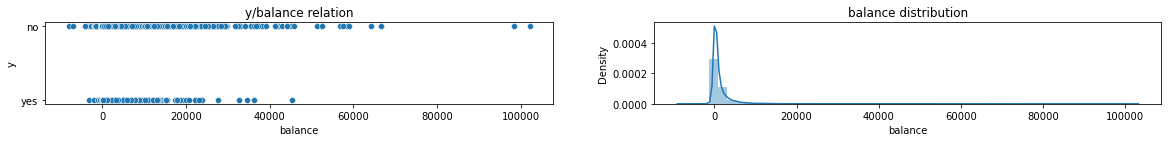

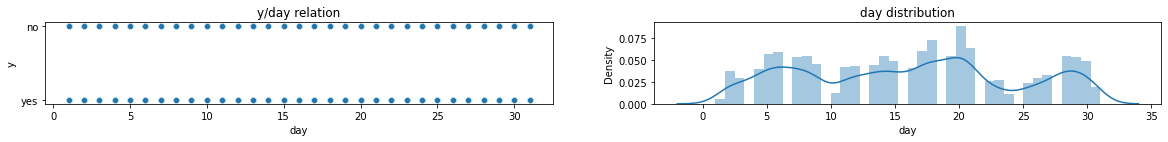

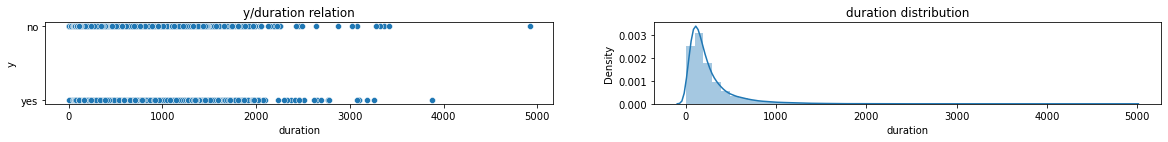

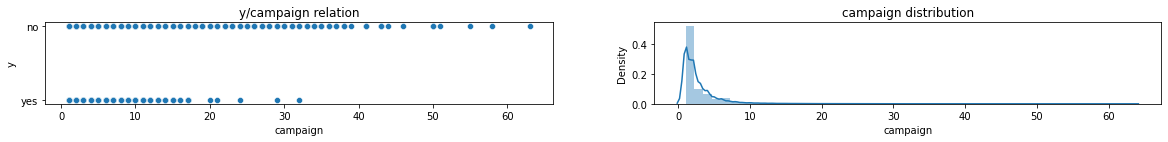

In [7]:
#VISUALIZE NUMERIC VALUES AND CHECK HOW THEY EFFECT the RESULT ("y") INDIVIDUALLY

def numericalDataAnalysis(featureNumeric):
    fig, axes = plt.subplots(1, 2, figsize=(20, 1.5))
    sns.scatterplot(ax=axes[0], data=DataTraining, x= DataTraining[featureNumeric], y= DataTraining["y"]).set_title("y/" + featureNumeric + " relation")
    sns.distplot(DataTraining[featureNumeric]).set_title(featureNumeric + " distribution")
    
numericalDataAnalysis('age')      
numericalDataAnalysis('balance')
numericalDataAnalysis('day')      
numericalDataAnalysis('duration')
numericalDataAnalysis('campaign')

In [8]:
#make a copy of the unprocessed data
DataTraining_NotProcessed = DataTraining.copy()

# - "y"        1-One Hot Encoding
# - "age"      1-outlier analysis 2-standardize 
# - "balance   1-outlier analysis 2-standardize
# - "day"      1-REMOVE, not useful
# - "duration  1-outlier analysis 2-standardize
# - "campaign" 1-produce, "Num_of_ppl_in_campaign" then remove "campaign" 2-standardize

In [9]:
#one hot encode the y
le = LabelEncoder()
DataTraining['y']= le.fit_transform(DataTraining['y']) # no-> 0 yes-> 1

In [10]:
#OUTLIER ANALYSIS, USING "DBSCAN"

def outlierAnalysis(feature, EPS, min_samples_to_remove):
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 1.7))
    featureFilterModel = DBSCAN(eps = EPS, min_samples = min_samples_to_remove).fit(DataTraining[[feature,"y"]]) #Filter
    
    sns.boxplot(ax=axes[0], x=DataTraining[feature]).set_title(feature + " distribution before filtering")
    sns.scatterplot(data=DataTraining, x=feature, y="y", hue=featureFilterModel.labels_, style=featureFilterModel.labels_).set_title(feature + " outlier values to be filtered")
    
    featureOutliers = DataTraining[featureFilterModel.labels_ == -1]
    
    return featureOutliers

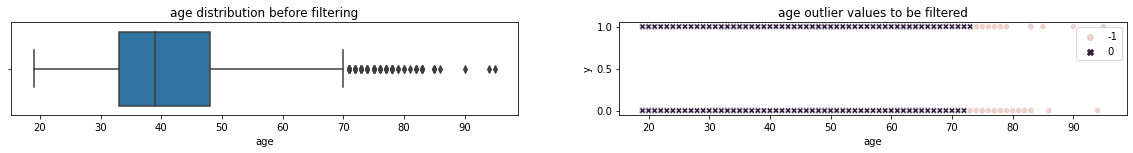

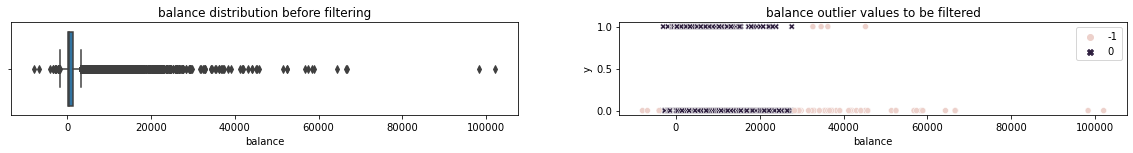

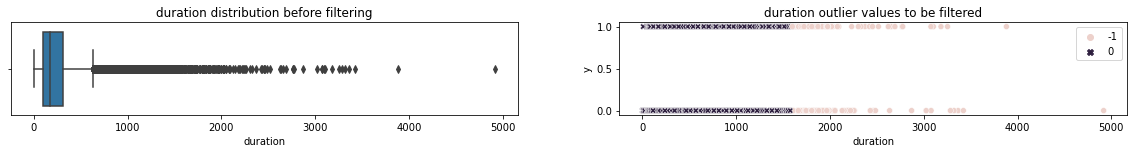

In [11]:
ageOutliers = outlierAnalysis("age", 1 ,17) #remove -1 values
balanceOutliers = outlierAnalysis("balance", 1000, 15) #remove -1 values
durationOutliers = outlierAnalysis("duration", 10, 10) #remove -1 values

In [12]:
#FILTER ALL DETECTED OUTLIERS
DataTrainingFilterAge = pd.concat([DataTraining, ageOutliers]).drop_duplicates(keep=False)
DataTrainingFilterBalance = pd.concat([DataTrainingFilterAge, balanceOutliers]).drop_duplicates(keep=False)
DataTraining_OutliersFiltered = pd.concat([DataTrainingFilterBalance, durationOutliers]).drop_duplicates(keep=False)

In [13]:
print("AMOUNT OF OUTLIERS REMOVED:")
print(DataTraining.shape[0] - DataTraining_OutliersFiltered.shape[0])

AMOUNT OF OUTLIERS REMOVED:
257


In [14]:
#ADD A FEATURE REPRESENTING HOW MANY PEOPLE ARE IN THIS PERSONS CAMPAIGN then remove "campaign"
CampaignValueCounsDF = DataTraining_OutliersFiltered["campaign"].value_counts().to_frame() # CATEGORIZE AS, over 1000 || 999-100 || 99-10 || under 10
CampaignValueCounsDF = CampaignValueCounsDF.rename(columns={"campaign" : "Num_of_ppl_in_campaign"})
DataTraining_OutliersFiltered = pd.merge(DataTraining_OutliersFiltered,CampaignValueCounsDF, left_on="campaign", right_index = True)
del DataTraining_OutliersFiltered["campaign"]

In [15]:
#REMOVING THE "day" FEATURE AS IT HAS NO EFFECT ON THE RESULT
DataTraining_OutliersFiltered = DataTraining_OutliersFiltered.drop(columns = ["day"])

In [16]:
#STANDARDIZE, "age" - "balance" - "duration" - "Num_of_ppl_in_campaign"

# Get columns to standardize
names = DataTraining_OutliersFiltered[["age","balance","duration","Num_of_ppl_in_campaign"]]

#Create the Scaler
scaler =  preprocessing.StandardScaler()

#Fit data on to the standart scale
scaled_df = scaler.fit_transform(names)
scaled_df = pd.DataFrame(scaled_df, columns= ["age","balance","duration","Num_of_ppl_in_campaign"])

In [17]:
#ADD "y" TO THE STANDARDIZED DATASET AND CHECK OUT THE CORRELATION MATRIX
corrDf = pd.merge(scaled_df, DataTraining_OutliersFiltered[["y"]], left_index=True, right_index=True)

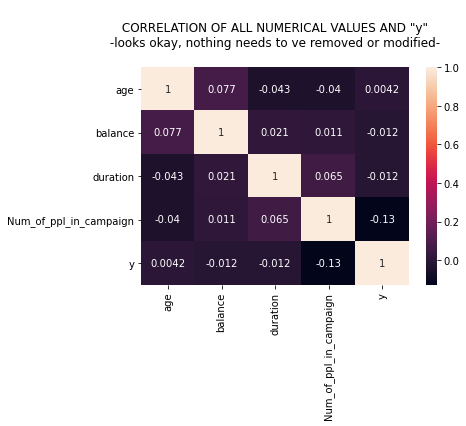

In [18]:
#CORRELATION MATRIX OF ALL NUMERICAL VALUES AND "y"
sns.heatmap(corrDf.corr(), annot=True).set_title('\n CORRELATION OF ALL NUMERICAL VALUES AND "y" \n -looks okay, nothing needs to ve removed or modified- \n')
plt.show()
#USE VISUALIZED CLUSTERING TO MODIFY CATEGORICAL DATA 
#CLUESTERİNG VİSUALİZATİON

In [19]:
#NOW WE PRE-PROCESS THE CATEGORICAL DATA  || for "y" # no-> 0 yes-> 1

# - "job"         1-ONE HOT ENCODE         
# - "marital"     1-ONE HOT ENCODE
# - "education"   1-ONE HOT ENCODE
# - "default"     1-ONE HOT ENCODE
# - "housing"     1-ONE HOT ENCODE
# - "loan"        1-ONE HOT ENCODE
# - "contact"     1-ONE HOT ENCODE
# - "month"       1-REMOVE

In [20]:
def categoricalDataAnalysis(featureCategoric):
    print("\n----" + featureCategoric + " value distribution" + "----\n")
    print(DataTraining_OutliersFiltered[featureCategoric].value_counts())
    print("\n\n----" + featureCategoric + " average y value (yes-> 1 no-> 0)" + "----\n")
    print(DataTraining_OutliersFiltered.groupby(featureCategoric)["y"].mean())

In [21]:
categoricalDataAnalysis("job")


----job value distribution----

blue-collar      9348
management       8113
technician       6819
admin            4463
services         3891
self-employed    1403
entrepreneur     1397
retired          1383
unemployed       1090
housemaid        1080
student           522
unknown           234
Name: job, dtype: int64


----job average y value (yes-> 1 no-> 0)----

job
admin            0.075958
blue-collar      0.055413
entrepreneur     0.061560
housemaid        0.046296
management       0.080981
retired          0.092552
self-employed    0.076978
services         0.058854
student          0.155172
technician       0.070392
unemployed       0.081651
unknown          0.068376
Name: y, dtype: float64


In [22]:
categoricalDataAnalysis("marital")


----marital value distribution----

married     24228
single      10829
divorced     4686
Name: marital, dtype: int64


----marital average y value (yes-> 1 no-> 0)----

marital
divorced    0.078532
married     0.058527
single      0.091883
Name: y, dtype: float64


In [23]:
categoricalDataAnalysis("education")


----education value distribution----

secondary    20887
tertiary     11122
primary       6213
unknown       1521
Name: education, dtype: int64


----education average y value (yes-> 1 no-> 0)----

education
primary      0.052149
secondary    0.065208
tertiary     0.090092
unknown      0.061144
Name: y, dtype: float64


In [24]:
categoricalDataAnalysis("default")


----default value distribution----

no     38936
yes      807
Name: default, dtype: int64


----default average y value (yes-> 1 no-> 0)----

default
no     0.070166
yes    0.060719
Name: y, dtype: float64


In [25]:
categoricalDataAnalysis("housing")


----housing value distribution----

yes    23923
no     15820
Name: housing, dtype: int64


----housing average y value (yes-> 1 no-> 0)----

housing
no     0.087105
yes    0.058646
Name: y, dtype: float64


In [26]:
categoricalDataAnalysis("loan")


----loan value distribution----

no     32842
yes     6901
Name: loan, dtype: int64


----loan average y value (yes-> 1 no-> 0)----

loan
no     0.073625
yes    0.052601
Name: y, dtype: float64


In [27]:
categoricalDataAnalysis("contact")


----contact value distribution----

cellular     24766
unknown      12706
telephone     2271
Name: contact, dtype: int64


----contact average y value (yes-> 1 no-> 0)----

contact
cellular     0.087459
telephone    0.064289
unknown      0.036912
Name: y, dtype: float64


In [28]:
categoricalDataAnalysis("month")
DataTraining_OutliersFiltered = DataTraining_OutliersFiltered.drop(columns = ["month"])
#We remove month since there aret enough data instances for each month which will result in bad generalization


----month value distribution----

may    13476
jul     6351
aug     5187
jun     4714
nov     3569
apr     2678
feb     2264
jan     1168
mar      247
oct       76
dec       13
Name: month, dtype: int64


----month average y value (yes-> 1 no-> 0)----

month
apr    0.162435
aug    0.053981
dec    0.076923
feb    0.105565
jan    0.029110
jul    0.057786
jun    0.060034
mar    0.473684
may    0.056842
nov    0.059400
oct    0.618421
Name: y, dtype: float64


In [29]:
#ONE HOT ENCODE ALL CATEGORICAL DATA
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["job"], prefix=["job"])
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["marital"], prefix=["marital"])
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["education"], prefix=["education"])
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["default"], prefix=["default"])
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["housing"], prefix=["housing"])
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["loan"], prefix=["loan"])
DataTraining_OutliersFiltered = pd.get_dummies(DataTraining_OutliersFiltered, columns=["contact"], prefix=["contact"])

In [30]:
#COMBINE SCALED NUMERICAL FEATURES WITH ENCODED CATEGORICAL FEATURES
DataTraining_OutliersFiltered = DataTraining_OutliersFiltered.drop(columns = ["age", "balance", "duration", "Num_of_ppl_in_campaign"])
DataPreProcessed = DataTraining_OutliersFiltered.join(scaled_df)
DataPreProcessed = pd.merge(DataTraining_OutliersFiltered,scaled_df, left_index= True, right_index = True)
print("Our Data After PreProcessing: \n")
DataPreProcessed.head()

Our Data After PreProcessing: 



,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,balance,duration,Num_of_ppl_in_campaign
0,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,0,1,1.836861,0.377092,0.055533,0.988475
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0.368948,-0.487600,-0.416691,0.988475
2,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,-0.784413,-0.498644,-0.738662,0.988475
3,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0.683501,0.116539,-0.669975,0.988475
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,-0.784413,-0.499053,-0.214923,0.988475


In [31]:
#Creating Feature Vectors for the training data and dealing with the imbalance which has about 1 to 10 ratio
X = DataPreProcessed.loc[:, DataPreProcessed.columns != 'y'].values
Y = DataPreProcessed.loc[:, DataPreProcessed.columns == 'y'].values

#DEALING WITH THE IMBALANCE BY OVERSAMPLING THE "y=yes" (there is about 10 no for each yes) 
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [32]:
# 5-FOLD CROSS VALIDATION
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=None)
for train_index, val_index in rkf.split(X):
     X_train, X_test = X[train_index], X[val_index]
     Y_train, Y_test = Y[train_index], Y[val_index]

In [33]:
#TRAINING OUR MODELS || K-nn -- Desicion Tree -- Random Forest Model

In [34]:
#K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski')  #------->K-NN Model
knn.fit(X_train,Y_train) #Training

Y_pred = knn.predict(X_test) #Prediction

cm = confusion_matrix(Y_test,Y_pred)
print(" *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*  K-NN Model  *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
print('Confusion Matrix: \n')
print(cm)
print("\n")

print('Average Accuracy: \n')  
print(accuracy_score(Y_test, Y_pred))
print("\n")

print('Classification Report: (yes-> 1 no-> 0) \n')
print(classification_report(Y_test, Y_pred))

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*  K-NN Model  *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Confusion Matrix: 

[[5862 1557]
 [ 253 7048]]


Average Accuracy: 

0.8770380434782609


Classification Report: (yes-> 1 no-> 0) 

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      7419
           1       0.82      0.97      0.89      7301

    accuracy                           0.88     14720
   macro avg       0.89      0.88      0.88     14720
weighted avg       0.89      0.88      0.88     14720



In [35]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy')  #-------->Desicion Tree Model
dtc.fit(X_train,Y_train) #Training

Y_pred = dtc.predict(X_test) #Prediction

cm = confusion_matrix(Y_test,Y_pred)
print(" *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*  DECISION TREE  *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
print('Confusion Matrix: \n')
print(cm)
print("\n")

print('Average Accuracy: \n')  
print(accuracy_score(Y_test, Y_pred))
print("\n")

print('Classification Report: (yes-> 1 no-> 0) \n')
print(classification_report(Y_test, Y_pred))

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*  DECISION TREE  *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Confusion Matrix: 

[[6561  858]
 [ 702 6599]]


Average Accuracy: 

0.8940217391304348


Classification Report: (yes-> 1 no-> 0) 

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7419
           1       0.88      0.90      0.89      7301

    accuracy                           0.89     14720
   macro avg       0.89      0.89      0.89     14720
weighted avg       0.89      0.89      0.89     14720



In [36]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, criterion = 'entropy') #-------->Random Forest Model
rfc.fit(X_train,Y_train) #Training

Y_pred = rfc.predict(X_test) #Prediction

cm = confusion_matrix(Y_test,Y_pred)
print(" *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-  RANDOM FOREST  *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
print('Confusion Matrix: \n')
print(cm)
print("\n")

print('Average Accuracy: \n')  
print(accuracy_score(Y_test, Y_pred))
print("\n")

print('Classification Report: (yes-> 1 no-> 0) \n')
print(classification_report(Y_test, Y_pred))

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-  RANDOM FOREST  *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Confusion Matrix: 

[[7013  406]
 [ 469 6832]]


Average Accuracy: 

0.9405570652173914


Classification Report: (yes-> 1 no-> 0) 

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7419
           1       0.94      0.94      0.94      7301

    accuracy                           0.94     14720
   macro avg       0.94      0.94      0.94     14720
weighted avg       0.94      0.94      0.94     14720

